<a href="https://colab.research.google.com/github/aaaraafaat/ML-/blob/main/ML_TIme_Series_Forecasting_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries for data manipulation, visualization, and machine learning.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU

In [2]:
# --- STEP 1: DATA LOADING AND INITIAL ANALYSIS ---

# Load the Nile River flow dataset from the provided CSV file.
# This dataset represents the annual flow volume of the River Nile from 1871 to 1970.

data = pd.read_csv('https://raw.githubusercontent.com/aaaraafaat/ML-/refs/heads/main/Nile_ts.csv')

# The original CSV has a column named "x". We'll rename it for clarity.
data.rename(columns={'x': 'Flow'}, inplace=True)

# Since the CSV does not contain a date column, we will create a synthetic time index.
# The standard time period for this dataset is 1871-1970.
date_index = pd.date_range(start='1871', end='1971', freq='A') # 'A' for Annual frequency
data.index = date_index
data = data['Flow']

/tmp/ipython-input-69395264.py:13: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  date_index = pd.date_range(start='1871', end='1971', freq='A') # 'A' for Annual frequency


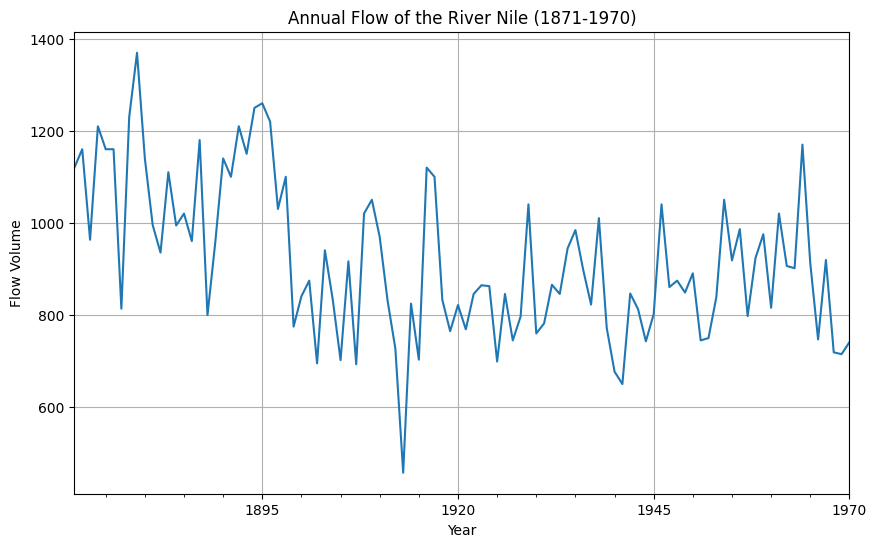

In [3]:
# Visualize the time series data to observe its characteristics.
# Note the apparent change point (a drop in flow) around the year 1900.
plt.figure(figsize=(10, 6))
data.plot()
plt.title("Annual Flow of the River Nile (1871-1970)")
plt.xlabel("Year")
plt.ylabel("Flow Volume")
plt.grid(True)
plt.show()

In [4]:
# --- STEP 2: DATA PREPROCESSING ---

# Scale the data to a specific range, typically [0, 1]. Normalization is crucial for
# neural networks as it helps them converge faster and perform better.
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.values.reshape(-1, 1))

# Define a function to convert the time series into a supervised learning format.
# This function creates sequences of past observations (lags) as input features (X)
# and the subsequent observation as the target variable (y).
def create_lagged_data(data, lag=1):
    X, y = [], []
    for i in range(len(data) - lag):
        # Append a sequence of 'lag' length as a feature
        X.append(data[i:i + lag])
        # Append the next value as the target
        y.append(data[i + lag])
    return np.array(X), np.array(y)

# Set the lag value. Since this data is annual and lacks strong seasonality,
# a smaller lag is more appropriate than the 12 used for monthly airline data.
# A lag of 10 will use the past 10 years of flow to predict the next year.
lag = 10
X, y = create_lagged_data(data_scaled, lag)

# Reshape the input data to the format [samples, time steps, features].
# This 3D format is a requirement for Recurrent Neural Networks like LSTM and GRU.
X = X.reshape(X.shape[0], X.shape[1], 1)


In [5]:
# --- STEP 3: TRAIN-TEST SPLIT ---

# Split the dataset into training and testing sets in a chronological order.
# The first 80% of the sequences will be used for training, and the remaining 20% for testing.
split_ratio = 0.8
split_index = int(len(X) * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [ ]:
# --- STEP 4 & 5: MODEL TRAINING, PREDICTION, AND EVALUATION ---


In [6]:
# --- Model 1: Random Forest ---
print("Training Random Forest...")
# Reshape the 3D input data to 2D for the Random Forest model.
X_train_rf = X_train.reshape(X_train.shape[0], -1)
X_test_rf = X_test.reshape(X_test.shape[0], -1)

# Initialize and train the Random Forest Regressor.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train.ravel())

# Make predictions on the test set.
y_pred_rf = rf_model.predict(X_test_rf)

# Calculate and store the Root Mean Squared Error (RMSE).
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"Random Forest RMSE: {rf_rmse:.4f}\n")

Training Random Forest...
Random Forest RMSE: 0.1563



In [7]:
# --- Model 2: Support Vector Machine (SVM) ---
print("Training SVM...")
# Reshape the input data to 2D, similar to Random Forest.
X_train_svm = X_train.reshape(X_train.shape[0], -1)
X_test_svm = X_test.reshape(X_test.shape[0], -1)

# Initialize and train the Support Vector Regressor (SVR).
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train_svm, y_train.ravel())

# Make predictions and evaluate the model's performance.
y_pred_svm = svm_model.predict(X_test_svm)
svm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_svm))
print(f"SVM RMSE: {svm_rmse:.4f}\n")

Training SVM...
SVM RMSE: 0.1352



In [8]:
# --- Model 3: Artificial Neural Network (ANN) ---
print("Training ANN...")
# Reshape input for the ANN to a 2D format [samples, features].
X_train_ann = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test_ann = X_test.reshape(X_test.shape[0], X_test.shape[1])

# Build the ANN model using a Sequential architecture.
ann_model = Sequential()
ann_model.add(Dense(64, input_dim=X_train_ann.shape[1], activation='relu'))
ann_model.add(Dense(32, activation='relu'))
ann_model.add(Dense(1))

# Compile the model, specifying the optimizer and the loss function.
ann_model.compile(optimizer='adam', loss='mse')

# Train the model for 100 epochs.
ann_model.fit(X_train_ann, y_train, epochs=100, batch_size=16, verbose=0)

# Make predictions and evaluate the model.
y_pred_ann = ann_model.predict(X_test_ann)
ann_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ann))
print(f"ANN RMSE: {ann_rmse:.4f}\n")

Training ANN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
ANN RMSE: 0.1300



In [9]:
# --- Model 4: Long Short-Term Memory (LSTM) ---
print("Training LSTM...")
# Build the LSTM model, which uses the 3D input shape.
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(1))

# Compile and train the LSTM model.
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)

# Make predictions and evaluate the model.
y_pred_lstm = lstm_model.predict(X_test)
lstm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
print(f"LSTM RMSE: {lstm_rmse:.4f}\n")


Training LSTM...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
LSTM RMSE: 0.1352



In [10]:
# --- Model 5: Gated Recurrent Unit (GRU) ---
print("Training GRU...")
# Build the GRU model, which has a similar architecture to the LSTM.
gru_model = Sequential()
gru_model.add(GRU(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
gru_model.add(GRU(50, return_sequences=False))
gru_model.add(Dense(1))

# Compile and train the GRU model.
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)

# Make predictions and evaluate the model.
y_pred_gru = gru_model.predict(X_test)
gru_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gru))
print(f"GRU RMSE: {gru_rmse:.4f}\n")

Training GRU...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
GRU RMSE: 0.1378



In [11]:
# --- STEP 6: RESULTS VISUALIZATION AND COMPARISON ---

# Store RMSE results in a dictionary for comparison
rmse_results = {
    'Random Forest': rf_rmse,
    'SVM': svm_rmse,
    'ANN': ann_rmse,
    'LSTM': lstm_rmse,
    'GRU': gru_rmse
}

# Display the final RMSE scores for all models.
print("--- RMSE Comparison for Models ---")
for model, rmse in rmse_results.items():
    print(f"{model}: {rmse:.4f}")

--- RMSE Comparison for Models ---
Random Forest: 0.1563
SVM: 0.1352
ANN: 0.1300
LSTM: 0.1352
GRU: 0.1378


/tmp/ipython-input-860516521.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(rmse_results.keys()), y=list(rmse_results.values()), palette="viridis")


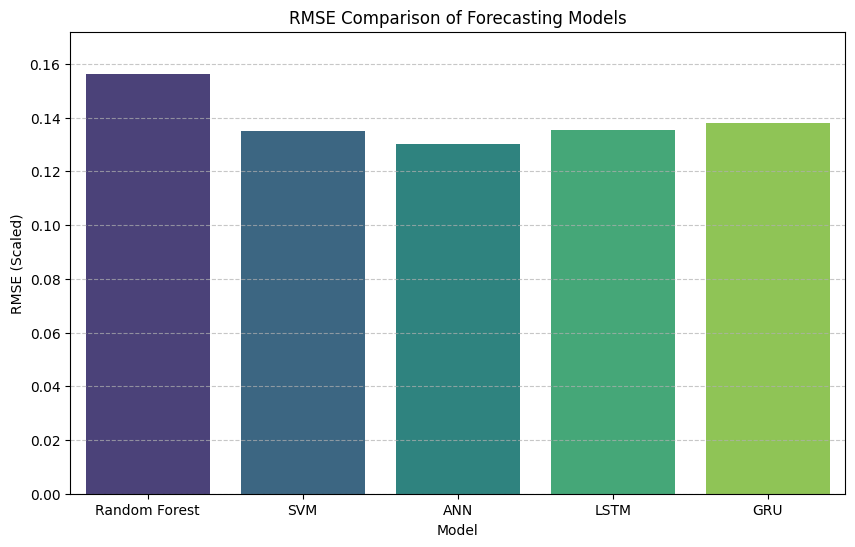

In [12]:
# Plot the RMSE comparison as a bar chart.
plt.figure(figsize=(10, 6))
sns.barplot(x=list(rmse_results.keys()), y=list(rmse_results.values()), palette="viridis")
plt.title('RMSE Comparison of Forecasting Models')
plt.xlabel('Model')
plt.ylabel('RMSE (Scaled)')
plt.ylim(0, max(rmse_results.values()) * 1.1)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


In [13]:
# Inverse transform the scaled predictions and actual values to their original flow volumes.
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_rf_inv = scaler.inverse_transform(y_pred_rf.reshape(-1, 1)).flatten()
y_pred_svm_inv = scaler.inverse_transform(y_pred_svm.reshape(-1, 1)).flatten()
y_pred_ann_inv = scaler.inverse_transform(y_pred_ann.reshape(-1, 1)).flatten()
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm.reshape(-1, 1)).flatten()
y_pred_gru_inv = scaler.inverse_transform(y_pred_gru.reshape(-1, 1)).flatten()

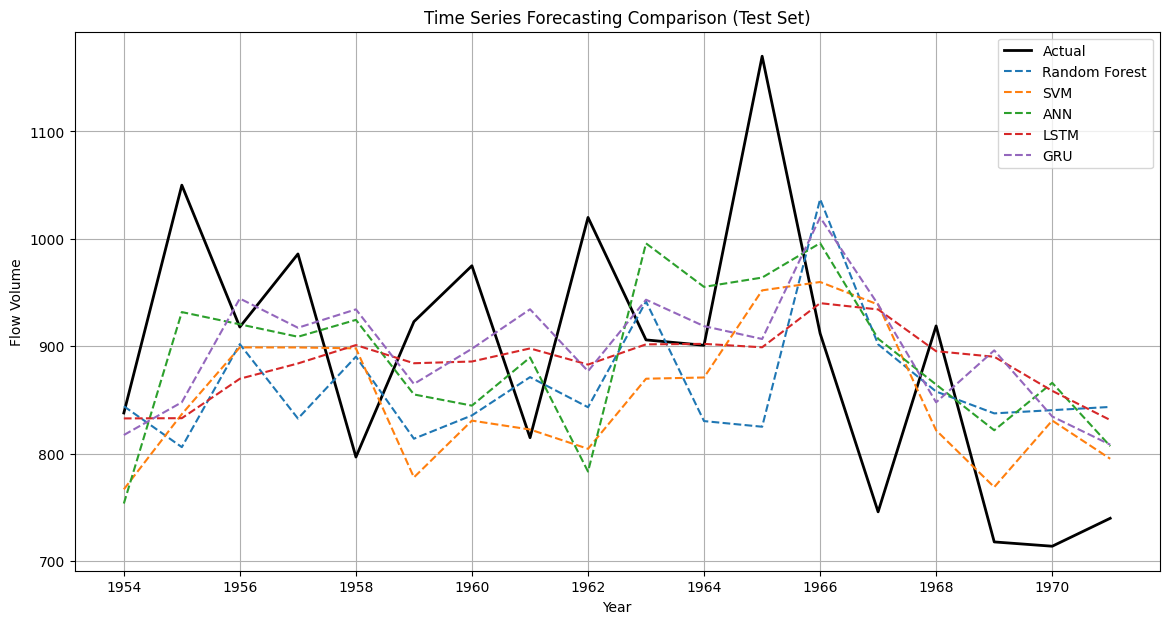

In [14]:
# Get the correct date index for the test set for plotting.
test_index = data.index[lag + len(y_train):]

# Plot the actual test data against the predictions from all models.
plt.figure(figsize=(14, 7))
plt.plot(test_index, y_test_inv, label='Actual', color='black', linewidth=2)
plt.plot(test_index, y_pred_rf_inv, label='Random Forest', linestyle='--')
plt.plot(test_index, y_pred_svm_inv, label='SVM', linestyle='--')
plt.plot(test_index, y_pred_ann_inv, label='ANN', linestyle='--')
plt.plot(test_index, y_pred_lstm_inv, label='LSTM', linestyle='--')
plt.plot(test_index, y_pred_gru_inv, label='GRU', linestyle='--')

plt.title('Time Series Forecasting Comparison (Test Set)')
plt.xlabel('Year')
plt.ylabel('Flow Volume')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
# --- STEP 7: FUTURE FORECASTING WITH THE BEST MODEL ---

# 1: Identify the best model based on the lowest RMSE score.
best_model_name = min(rmse_results, key=rmse_results.get)

# 2. Map model name to model object
best_model = {
    'Random Forest': rf_model,
    'SVM': svm_model,
    'ANN': ann_model,
    'LSTM': lstm_model,
    'GRU': gru_model
}[best_model_name]
print(f"\n--- Generating 20-Year Forecast with Best Model: {best_model_name} ---")

# Set forecasting parameters. A 20-year forecast is chosen as an example.
forecast_steps = 20

# 3. Prepare initial input sequence for forecasting: last `lag` data points scaled
# Start with the last known sequence from the original data.
last_sequence = data_scaled[-lag:].reshape(1, lag, 1)
forecast_scaled = []

# Iteratively predict future steps.
for _ in range(forecast_steps):
    # Reshape input based on the best model's requirements.
    if best_model_name in ['LSTM', 'GRU']:
        input_seq = last_sequence
    else: # RF, SVM, ANN
        input_seq = last_sequence.reshape(1, lag)

    # Predict the next time step.
    next_pred_scaled = best_model.predict(input_seq)[0]
    # Ensure the prediction is a single scalar value.
    if isinstance(next_pred_scaled, np.ndarray):
        next_pred_scaled = next_pred_scaled[0]

    forecast_scaled.append(next_pred_scaled)

    # Update the sequence: remove the oldest value and append the new prediction.
    new_sequence = np.append(last_sequence.flatten()[1:], next_pred_scaled)
    last_sequence = new_sequence.reshape(1, lag, 1)

# 5. Inverse transform the forecasted values back to the original scale.
forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()

# 6. Create future dates starting after last date in data
last_date = data.index[-1]
future_dates = pd.date_range(last_date, periods=forecast_steps + 1, freq='A')[1:]



--- Generating 20-Year Forecast with Best Model: ANN ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


/tmp/ipython-input-897451720.py:50: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  future_dates = pd.date_range(last_date, periods=forecast_steps + 1, freq='A')[1:]


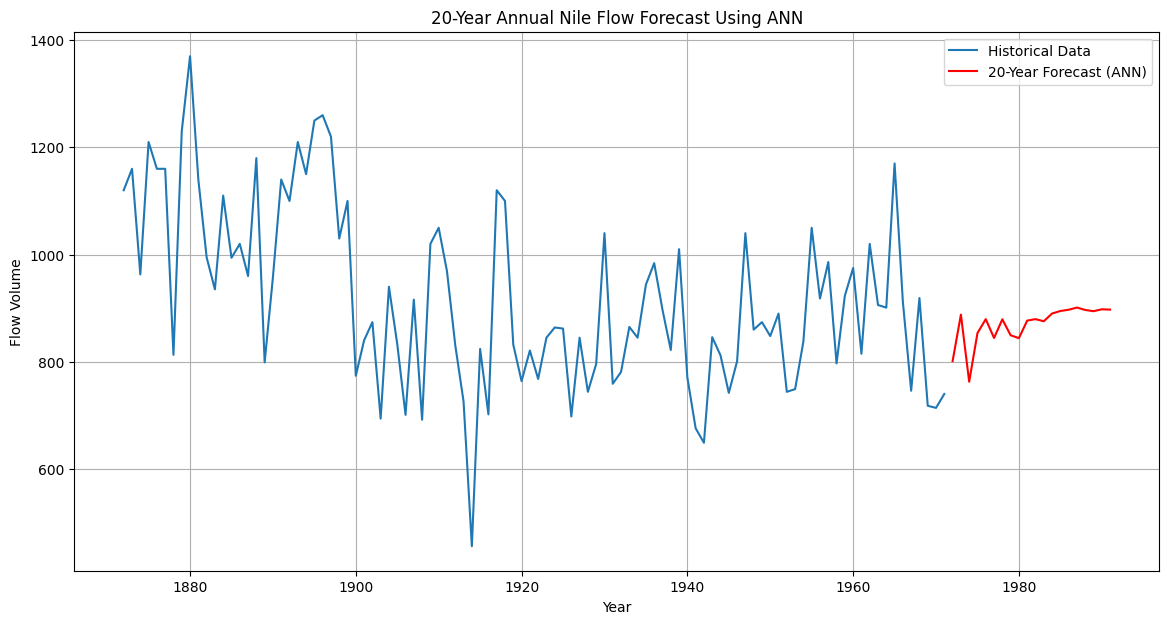

In [23]:
# 7 Plot the original historical data along with the new 20-year forecast.
plt.figure(figsize=(14, 7))
plt.plot(data.index, data.values, label='Historical Data')
plt.plot(future_dates, forecast, label=f'20-Year Forecast ({best_model_name})', color='red')
plt.title(f'20-Year Annual Nile Flow Forecast Using {best_model_name}')
plt.xlabel('Year')
plt.ylabel('Flow Volume')
plt.legend()
plt.grid(True)
plt.show()



--- Generating 20-Year Forecast with Best Model: ANN ---
Iteration 0: next_pred type: <class 'numpy.float32'>, value: 0.3775941729545593
Iteration 1: next_pred type: <class 'numpy.float32'>, value: 0.47263213992118835
Iteration 2: next_pred type: <class 'numpy.float32'>, value: 0.3356831967830658
Iteration 3: next_pred type: <class 'numpy.float32'>, value: 0.434906542301178
Iteration 4: next_pred type: <class 'numpy.float32'>, value: 0.4634077548980713


/tmp/ipython-input-2283235199.py:59: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  future_dates = pd.date_range(start=last_date + pd.DateOffset(years=1), periods=forecast_steps, freq='A')


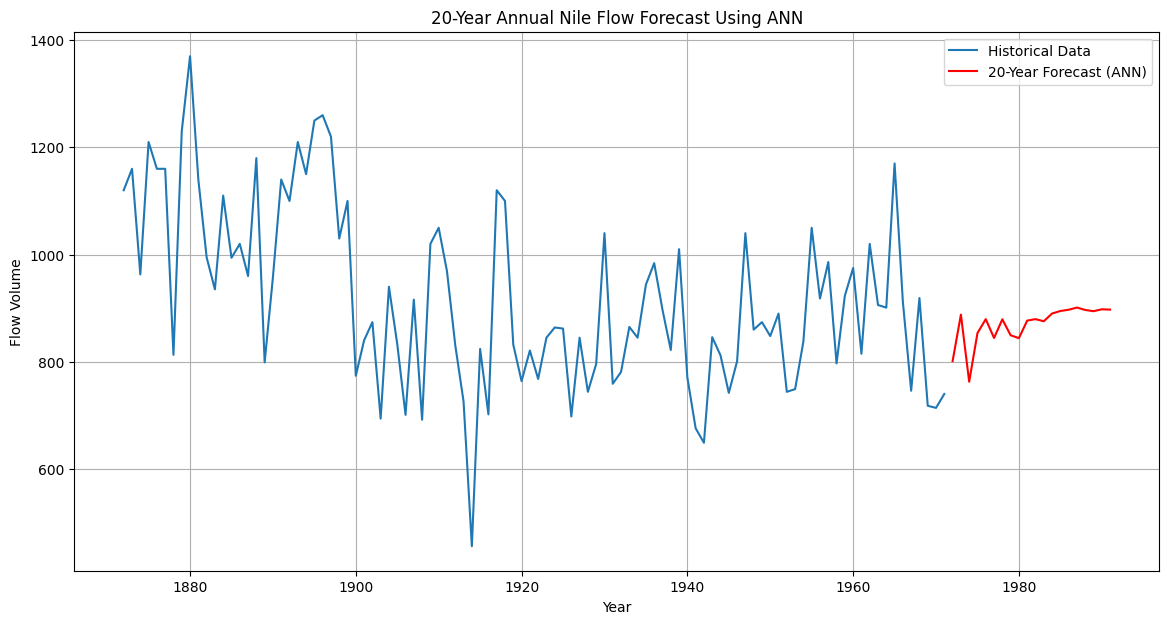

In [30]:
# --- STEP 7: FUTURE FORECASTING WITH THE BEST MODEL ---

# 1: Identify the best model based on the lowest RMSE score.
best_model_name = min(rmse_results, key=rmse_results.get)

# 2. Map model name to model object
best_model = {
    'Random Forest': rf_model,
    'SVM': svm_model,
    'ANN': ann_model,
    'LSTM': lstm_model,
    'GRU': gru_model
}[best_model_name]
print(f"\n--- Generating {forecast_steps}-Year Forecast with Best Model: {best_model_name} ---")

# Set forecasting parameters. A 20-year forecast is chosen as an example.
# forecast_steps is already defined earlier as 20
# lag is already defined earlier as 10

# Initialize forecast_scaled and last_sequence before the loop
forecast_scaled = []
last_sequence = data_scaled[-lag:].reshape(1, lag, 1)

# 4. Forecast loop depends on model type (reshape inputs accordingly)
for i in range(forecast_steps):
    if best_model_name in ['LSTM', 'GRU']:
        # For LSTM/GRU, input shape is (1, lag, 1)
        next_pred = best_model.predict(last_sequence, verbose=0)[0, 0]
        forecast_scaled.append(next_pred)
        # Update input sequence by appending prediction and removing oldest value
        last_sequence = np.append(last_sequence[:, 1:, :], [[[next_pred]]], axis=1)

    elif best_model_name == 'ANN':
        # ANN expects 2D input shape (samples, features)
        input_ann = last_sequence.reshape(1, lag)
        next_pred = best_model.predict(input_ann, verbose=0)[0, 0]
        forecast_scaled.append(next_pred)
        # Print type and value of next_pred for debugging
        if i < 5: # Print for first 5 iterations
            print(f"Iteration {i}: next_pred type: {type(next_pred)}, value: {next_pred}")
        # Update last_sequence accordingly
        new_seq = np.append(last_sequence.flatten()[1:], next_pred)
        last_sequence = new_seq.reshape(1, lag, 1)

    else:
        # For Random Forest and SVM: 2D input (samples, features)
        input_rf_svm = last_sequence.reshape(1, lag)
        next_pred = best_model.predict(input_rf_svm)[0]
        forecast_scaled.append(next_pred)
        new_seq = np.append(last_sequence.flatten()[1:], next_pred)
        last_sequence = new_seq.reshape(1, lag, 1)

# 5. Inverse transform the forecasted values back to the original scale.
forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()

# 6. Create future dates starting after last date in data
last_date = data.index[-1]
# Create dates for the exact number of forecast steps
future_dates = pd.date_range(start=last_date + pd.DateOffset(years=1), periods=forecast_steps, freq='A')

# 7. Plot historical data + forecast
plt.figure(figsize=(14, 7))
plt.plot(data.index, data.values, label='Historical Data')
plt.plot(future_dates, forecast, label=f'{forecast_steps}-Year Forecast ({best_model_name})', color='red')
plt.title(f'{forecast_steps}-Year Annual Nile Flow Forecast Using {best_model_name}')
plt.xlabel('Year') # Changed from Date
plt.ylabel('Flow Volume') # Changed from Number of Passengers
plt.legend()
plt.grid(True)
plt.show() # Removed tight_layout

In [36]:
# --- STEP 8: FUTURE FORECAST COMPARISON FOR ALL MODELS ---

all_models = {
    'Random Forest': rf_model,
    'SVM': svm_model,
    'ANN': ann_model,
    'LSTM': lstm_model,
    'GRU': gru_model
}
print("\n--- Generating Future Forecasts for All Models ---")
# Prepare dictionary to store forecasts for each model
forecasts = {}
# Prepare initial input sequence for forecasting
base_sequence = data_scaled[-lag:].reshape(1, lag, 1)

# Define a function to perform the iterative forecast for any given model.
def iterative_forecast(model, model_name, steps, initial_sequence, lag_size):
    seq = initial_sequence.copy()
    preds_scaled = []
    for _ in range(steps):
        # Reshape input based on model type
        if model_name in ['LSTM', 'GRU']:
            input_data = seq
        else:  # RF, SVM, ANN
            input_data = seq.reshape(1, lag_size)

        # Get prediction and ensure it's a scalar
        pred = model.predict(input_data)[0]
        if isinstance(pred, np.ndarray):
            pred = pred[0]

        preds_scaled.append(pred)

        # Update the sequence for the next prediction
        new_seq = np.append(seq.flatten()[1:], pred)
        seq = new_seq.reshape(1, lag_size, 1)

    return np.array(preds_scaled)

# Run the forecast for each model
for name, model_obj in all_models.items():
    preds_scaled = iterative_forecast(model_obj, name, forecast_steps, base_sequence, lag)
    preds_unscaled = scaler.inverse_transform(preds_scaled.reshape(-1, 1)).flatten()
    forecasts[name] = preds_unscaled





--- Generating Future Forecasts for All Models ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/ste

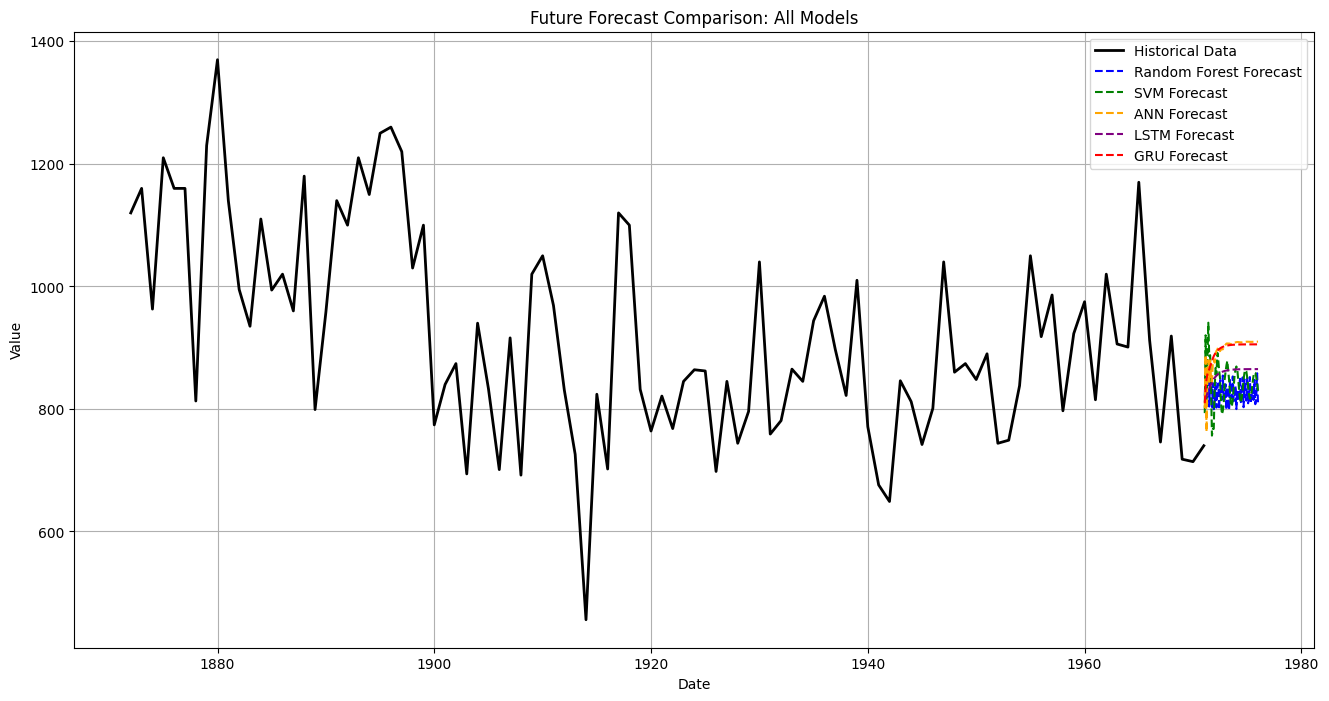

In [38]:
# Plot historical data + all forecasts for comparison
plt.figure(figsize=(16, 8))
plt.plot(data.index, data.values, label='Historical Data', color='black', linewidth=2)

# Define colors for each model's forecast line
colors = ['blue', 'green', 'orange', 'purple', 'red']
for color, (model_name, forecast_values) in zip(colors, forecasts.items()):
    plt.plot(future_dates, forecast_values, label=f'{model_name} Forecast', color=color, linestyle='--')

# TODO: Update the plot title and labels.
plt.title('Future Forecast Comparison: All Models')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.show()